<h1>Salary Prediciton Notebook</h1>

<h2>1 - Introduction</h2>
in this notebook I am going to study effects of different qualifications on the salary of an advertised position

<h2>2 - The Data</h2>
The data used in this analysis comes from bonus portfolio course from Data Science Dream Job (DSDJ)
and it contains the following:
<ul>
    <li><b>jobId:</b> a unique identifier of the job listing</li>
    <li><b>companyId:</b> a unique identifier of the comany that listed the job</li>
    <li><b>jobType:</b> the level of seniority</li>
    <li><b>industry:</b> the industry under which the job falls</li>
    <li><b>degree:</b> the minimum level of education required for the job</li>
    <li><b>major:</b> the major required for the job</li>
    <li><b>yearsExperience:</b> the years of experience requires for the job</li>
    <li><b>mileFromMetropolis:</b> the distance of the job location from the city center</li>
    <li><b>salary:</b> the salary of the advertised job</li>
</ul>

In [40]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error


from eda_utils import generate_eda_basic_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_job_listing_feature = pd.read_csv('.\\data\\train_features.csv')
df_job_listing_salaries = pd.read_csv('.\\data\\train_salaries.csv')
df_job_listings_unprocessed = df_job_listing_feature.merge(df_job_listing_salaries, on='jobId')

In [3]:
df_job_listings_unprocessed.columns

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis', 'salary'],
      dtype='object')

<h2>3 - EDA</h2><br/>
In this section we will explore the data in order to understand it further and maybe find some hidden insight that will help us in our modeling later

In [4]:
df_job_listings_unprocessed.shape

(1000000, 9)

In [5]:
df_job_listings_unprocessed.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

In [6]:
object_columns = ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']
num_columns = ['yearsExperience', 'milesFromMetropolis', 'salary']

In [7]:
report_path = 'Eda_Reports'
generate_eda_basic_report(df_job_listings_unprocessed[object_columns], path = report_path, file_name = 'cat_variables')
generate_eda_basic_report(df_job_listings_unprocessed[num_columns], path = report_path, file_name = 'num_variables',
                         include_value_counts = False)

In [7]:
cat_features = [ 'jobType', 'degree', 'major', 'industry']
num_features = ['yearsExperience', 'milesFromMetropolis']
target_variable = ['salary']

In [8]:
df_job_listings_real_salaries = df_job_listings_unprocessed[df_job_listings_unprocessed['salary'] != 0]

In [9]:
df_job_listings_real_salaries.shape

(999995, 9)

In [10]:
corelation_matrix = df_job_listings_real_salaries[num_features + target_variable].corr()
corelation_matrix

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.000672,0.375013
milesFromMetropolis,0.000672,1.000000,-0.297686
salary,0.375013,-0.297686,1.000000


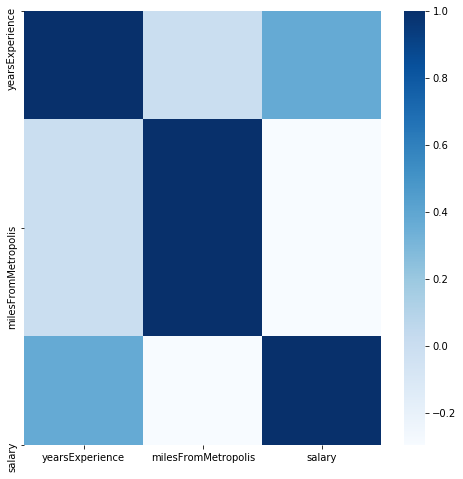

In [11]:
plt.figure(figsize=(8, 8))
sns.heatmap(corelation_matrix, cmap='Blues')

<h2>Result:</h2>
We see from the above that the salary has an inverse corelation with the milesFromMetropolis variable<br>
and a positive one with the years of experience while the two variables appear to be linearly independent<br>
of each other

<h5>Now we will examine the relationship of each variable alone and its relationship with the dependent variable</h5>

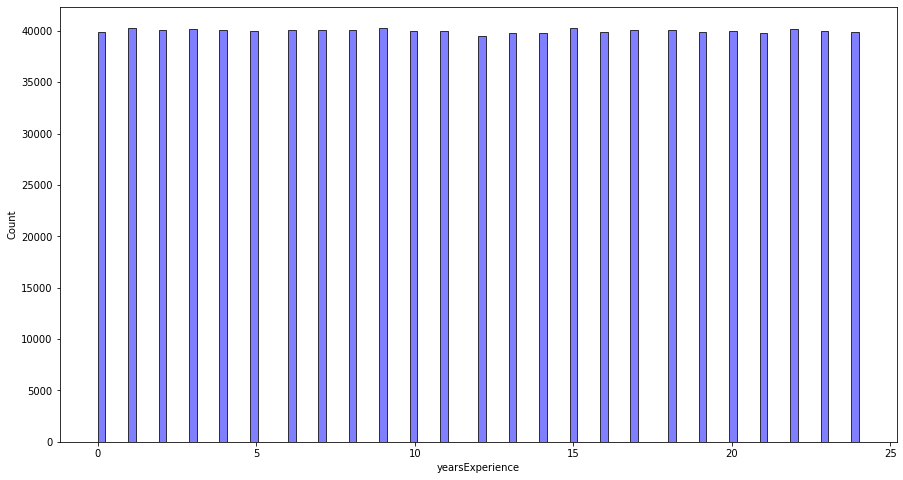

In [12]:
plt.figure(figsize=(15, 8))
sns.histplot(data = df_job_listings_real_salaries,x = df_job_listings_real_salaries['yearsExperience'], color = 'Blue',
            alpha = 0.5)

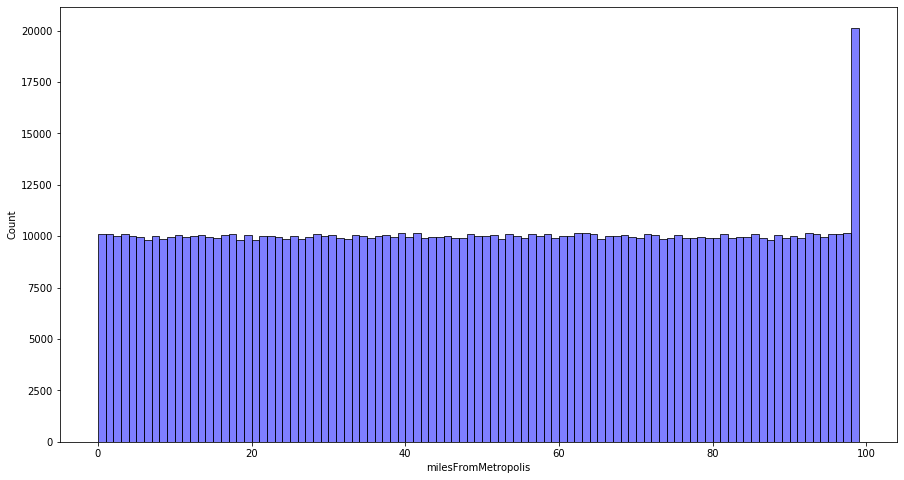

In [13]:
plt.figure(figsize=(15, 8))
sns.histplot(data = df_job_listings_real_salaries,x = df_job_listings_real_salaries['milesFromMetropolis'], color = 'Blue',
            alpha = 0.5)

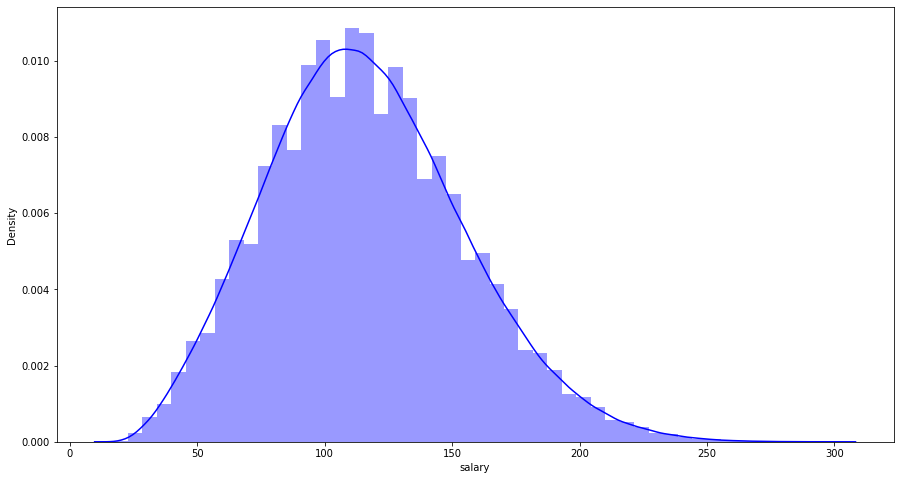

In [14]:
plt.figure(figsize=(15, 8))
sns.distplot(df_job_listings_real_salaries['salary'], color = 'Blue')

In [15]:
df_job_types_count = df_job_listings_real_salaries.groupby(['jobType'])['jobType'].agg(['count']).reset_index()
df_degree_count = df_job_listings_real_salaries.groupby(['degree'])['degree'].agg(['count']).reset_index()
df_industry_count = df_job_listings_real_salaries.groupby(['industry'])['industry'].agg(['count']).reset_index()
df_major_count = df_job_listings_real_salaries.groupby(['major'])['major'].agg(['count']).reset_index()

<BarContainer object of 9 artists>

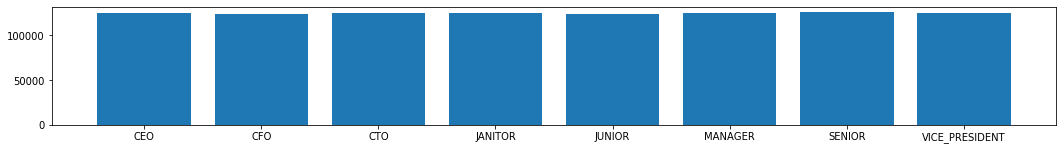

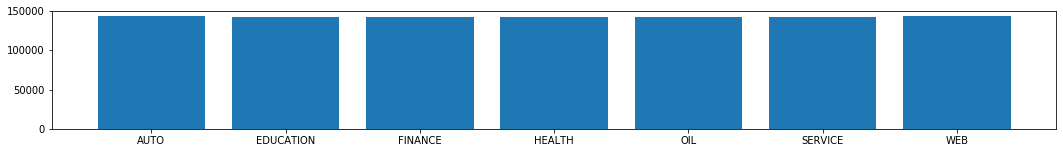

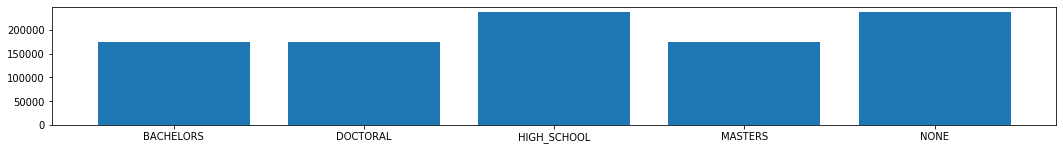

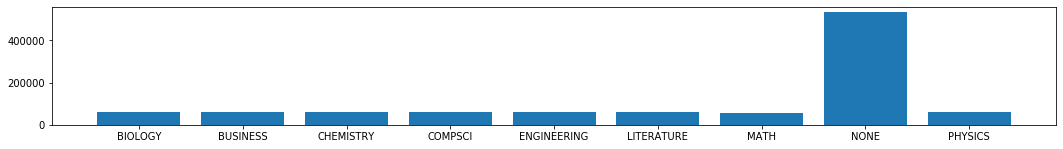

In [16]:
plt.figure(figsize=(18,10))
plt.subplot(4, 1, 1)
plt.bar(x = 'jobType', height = 'count', data = df_job_types_count)

plt.figure(figsize=(18,10))
plt.subplot(4, 1, 2)
plt.bar(x = 'industry', height = 'count', data = df_industry_count)

plt.figure(figsize=(18,10))
plt.subplot(4, 1, 3)
plt.bar(x = 'degree', height = 'count', data = df_degree_count)

plt.figure(figsize=(18,10))
plt.subplot(4, 1, 4)
plt.bar(x = 'major', height = 'count', data = df_major_count)


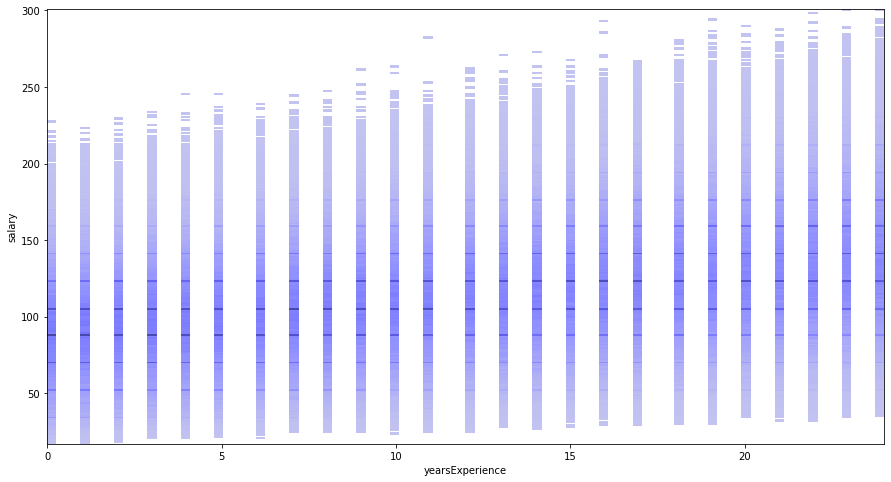

In [18]:
plt.figure(figsize=(15, 8))
sns.histplot(x = df_job_listings_real_salaries['yearsExperience'], y = df_job_listings_real_salaries['salary']
            ,color='Blue')

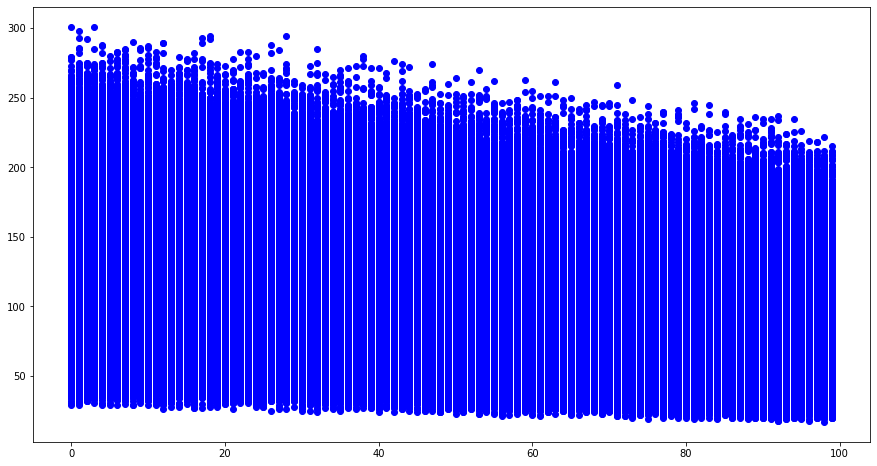

In [20]:
plt.figure(figsize=(15, 8))
plt.scatter(x = df_job_listings_real_salaries['milesFromMetropolis'], y = df_job_listings_real_salaries['salary']
            ,color='Blue')

In [26]:
df_job_types_industry_stats = df_job_listings_real_salaries\
.groupby(['jobType', 'industry'])['salary'].agg(['sum', 'mean', 'median', 'min', 'max']).reset_index()

df_degree_stats = df_job_listings_real_salaries\
.groupby(['degree'])['salary'].agg(['sum', 'mean', 'median', 'min', 'max']).reset_index()

df_industry_stats = df_job_listings_real_salaries\
.groupby(['industry'])['salary'].agg(['sum', 'mean', 'median', 'min', 'max']).reset_index()

df_major_stats = df_job_listings_real_salaries\
.groupby(['major'])['salary'].agg(['sum', 'mean', 'median', 'min', 'max']).reset_index()

In [27]:
df_job_types_industry_stats.sort_values(['industry']).to_csv('job_type_by_industry.csv')
df_degree_stats.to_csv('degree_value_stats.csv')
df_industry_stats.to_csv('industry_value_stats.csv')
df_major_stats.to_csv('major_value_stats.csv')

<h2>EDA Results:</h2>
  <ul>
   <li>I found five entires where salary is zero which does not make sense and since it is a very smal ratio
      of the data we dropped those five rows
   </li><br/>
   <li>The salary field seems to follow a near normal distribution</li>
   <li>I observed through multiple methods (statistically and visually) that the salary variable seems to have
      a positive relationship with the yearsExprerience variable and an inverse relationship with the milesFromMetropolis
      variable.
   </li><br/>
   <li>The data is uniformally distibuted for both the job_type and the industry variables which is a positive thing
      since there seems to be no imbalances
   </li><br/>
   <li>As for the "degree" variable I found that people with no degree or only high school degree seems to represent the 
       majority of people in the sample and an equal distribution for the rest of degree types
   </li><br/>
   <li>As for the "major" variable I found that it is mostly uniformally distributed with the exception of the people
       with no major as they have a higher count than the rest which makes sense given what I found about the "degree" variable
   </li><br/>
   <li>
       I found that CTO and CFO job_types has both similar disribution and salary statistics across industries, thus it can
       be beneficial to merge them into one feature in order to reduce the number of features when we apply one hot encoding
   </li>
  </ul>


<h2>4 - Data Preprocessing</h2>

<h5>For data preprocessing I am going to apply the following steps</h5>
<ul>
    <li>For numrical features I am going to extract polynomial features and then apply standard scaler</li>
    <li>For categorical features I am going to use only one hot enconding</li>
    <li>I am going to split the data into training and testing sets and since I will not be applying cross validation
        for the purpose of this study I will be needing a development set
    </li>
</ul>

In [29]:
df_features = df_job_listings_real_salaries[cat_features + num_features]
df_target = df_job_listings_real_salaries[target_variable]

In [31]:
df_features['jobType'] = df_features['jobType'].replace(to_replace = {'CFO' : 'CO', 'CTO': 'CO'})
df_features['jobType'].value_counts()

CO                249414
SENIOR            125886
VICE_PRESIDENT    125234
MANAGER           125120
JANITOR           124971
CEO               124778
JUNIOR            124592
Name: jobType, dtype: int64

In [34]:
poly = PolynomialFeatures(include_bias=False, degree=2)
num_transformer = Pipeline(steps=[('poly', poly), ('scaler', StandardScaler())])
cat_transformer = OneHotEncoder()

In [35]:
preprocessor = ColumnTransformer(
      transformers=[
          ('num', num_transformer, num_features), 
          ('cat', cat_transformer, cat_features)] ,remainder='drop')

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.02, random_state = 4589637)

<h2>5 - Modeling</h2>

for modeling I am going to use Lasso regression, I made this choice because my purpose of this study is more informative
rather than predictive and since Lasso uses L1 regularization which one of its properties is the fact it turn off features
that are not particularly useful by setting their coefficients to zero

In [36]:
final_pipe = Pipeline(steps=[('preprocessor',preprocessor), ('model', Lasso(max_iter=400000, alpha = 1e-2))])

In [41]:
final_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['yearsExperience',
                                                   'milesFromMetropolis']),
                                                 ('cat', OneHotEncoder(),
                                                  ['jobType', 'degree', 'major',
                                                   'industry'])])),
                ('model', Lasso(alpha=0.01, max_iter=400000))])

In [42]:
y_train_pred = final_pipe.predict(X_train)
y_test_pred = final_pipe.predict(X_test)

In [44]:
print('The mean squared error for the training set is {}'.format(mean_squared_error(y_train, y_train_pred)))
print('The mean squared error for the Testing set is {}'.format(mean_squared_error(y_test, y_test_pred)))

The mean squared error for the training set is 367.1743105314582
The mean squared error for the Testing set is 364.4254079134165


In [47]:
polynomial_features_names = final_pipe.named_steps['preprocessor'].named_transformers_['num']\
.named_steps['poly'].get_feature_names(num_features)

one_hot_features_names = final_pipe.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names(cat_features)

all_features_names = list(polynomial_features_names) + list(one_hot_features_names)

In [51]:
coef_df = pd.DataFrame(final_pipe.named_steps['model'].coef_)
coef_df['column'] = pd.Series(data=all_features_names)
coef_df.columns = ['coef', 'feature']
coef_df.sort_values(by = ['coef'], ascending = False)

,coef,feature
5,29.779709,jobType_CEO
0,21.562261,yearsExperience
6,20.009696,jobType_CO
30,15.013205,industry_OIL
28,14.859294,industry_FINANCE
13,9.956239,degree_DOCTORAL
11,9.827302,jobType_VICE_PRESIDENT
21,8.078796,major_ENGINEERING
32,5.807705,industry_WEB
18,5.175590,major_BUSINESS


<h2>6 - Findings and Insights</h2>

<ul>
    <li>we see that the greatest effect is the position as the greates positve effects include come from cheif officers
        (CEO, CTO, CFO), and the greatest negative effect comes from the janitor position.
    </li><br>
    <li>We observe that years of experience also has a huge positive effect on salary</li><br>
    <li>We also observe that the Oil and Finance industries has a large positve effect on the salary while
        the Service and Education industries seems to be mostly associated with lower salaries
    </li><br>
    <li>As we see bachelor degree does not seem to have a direct effect on salary while the higher the education
        the higher thepoistive effect it will have on salary and same goes for negative effect the lower the education
    </li>
</ul>